In [137]:
import torch
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
import random
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy
#from ML_models.BBBlayers import BBBLinearFactorial
#from ML_models.BBBlayers import GaussianVariationalInference
import seaborn as sns
from sklearn.metrics import f1_score

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.fftpack import fft

import os

In [138]:
pickle_path = "pickles"
features_file_name = "features_data.p"
cmm_file_name = "strath_outputs.p"

#dictionary which contains all phases, parts, sensors
features_data = pickle.load( open( pickle_path+"/"+features_file_name, "rb" ) )
output_df = pickle.load( open( pickle_path+"/"+cmm_file_name, "rb" ) )

In [139]:
class BNN_Dropout(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_Dropout, self).__init__()
        self.linear = torch.nn.Linear(input_size, (int)(input_size / 2))
        self.linear_2 = torch.nn.Linear((int)(input_size / 2), (int)(input_size / 4))
        self.linear_3 = torch.nn.Linear((int)(input_size / 4), (int)(input_size / 8))
        self.linear_4 = torch.nn.Linear((int)(input_size / 8), output_size)
        dropout_p = 0.2
        self.dropout_layer = torch.nn.Dropout(p=dropout_p)
                
    def forward(self,x):
        x_temp = self.linear(self.dropout_layer(x))
        x_temp = self.linear_2(self.dropout_layer(x_temp))
        x_temp = self.linear_3(self.dropout_layer(x_temp))
        x_temp = self.linear_4(x_temp)
        
        return x_temp


In [140]:
class ML_Wrapper():
    def __init__(self):
        self.trained_model = {}

    def train_model(self, x_train_tensor, y_train_tensor):
        self.trained_model = {}
        return self.trained_model

    def predict_model_wUnc(self, x_test_tensor, num_samples):
        pred = []
        unc = []
        confidences = []
        return [pred, unc,confidences]

In [141]:
class BNN_Wrapper(ML_Wrapper):
    def __init__(self,model,input_size=10,output_size=10):
        super().__init__()
        self.set_modelType(model,input_size,output_size)
        self.fitted_scalers = []

    def set_modelType(self,model,input_size,output_size):
        self.modelType = model
        self.input_size = input_size
        self.output_size = output_size
    def init_model(self,input_size=-1,output_size=-1):
        if input_size==-1:
            input_size= self.input_size
        if output_size==-1:
            output_size= self.output_size
        return self.modelType(input_size,output_size)
    
    def extract_features(self,X_data): 
        #get per line
        #convert to frequency domain
        freq_X = fft(X_data,axis=1)[:,1:(int)(X_data.shape[1]/2),:]
        def get_features(x_dt,axis=1):
            feat_skewness = skew(x_dt,axis=axis)
            feat_kurtosis = kurtosis(x_dt,axis=axis)
            feat_mean = np.mean(x_dt,axis=axis)
            feat_std = np.std(x_dt,axis=axis)
            feat_min = np.min(x_dt,axis=axis)
            feat_max = np.max(x_dt,axis=axis)
            feat_sum = np.sum(x_dt,axis=axis)
            feat_median = np.median(x_dt,axis=axis)
            return[[feat_skewness,feat_kurtosis,feat_mean,feat_std,feat_min,feat_max,feat_sum,feat_median],["skewness","kurtosis","mean","std","min","max","sum","median"]]
        ts_features = get_features(x_dt)
        ts_features[1] = ["ts_"+val for val in ts_features[1]]
        
        
        fq_features = get_features(freq_X)
        fq_features[1] = ["fq_"+val for val in fq_features[1]]
        
        col_names =ts_features[1] +fq_features[1]
        feat_list =ts_features[0] +fq_features[0]
                
        def convert_df(np_arr,col_name="kurto",col_num=15):
            column_names = [col_name+"_"+str(i) for i in range(col_num)]
            df_feats_temp = pd.DataFrame.from_records(np_arr)
            df_feats_temp.columns = column_names
            return df_feats_temp        
        for i,val in enumerate(col_names):
            if i ==0:
                df_feats = convert_df(np_arr=feat_list[i],col_name=col_names[i],col_num=X_data.shape[2])
            else:
                df_temp = convert_df(np_arr=feat_list[i],col_name=col_names[i],col_num=X_data.shape[2])
                df_feats=df_feats.join(df_temp) 
        return df_feats
    
    
    def fit_normalizer(self,x_train_not_normalized_yet):
        #self.fitted_scalers = [RobustScaler().fit(x_train_not_normalized_yet[:,i].reshape(-1, 1)) for i in range(x_train_not_normalized_yet.shape[-1]) ]
        self.fitted_scalers = [StandardScaler().fit(x_train_not_normalized_yet) ]
        return self.fitted_scalers
    def run_normalizer(self,x_train_normalized):
        #for i in range(len(self.fitted_scalers)):
        #    x_train_normalized[:,i] = self.fitted_scalers[i].transform(x_train_normalized[:,i].reshape(-1, 1)).reshape(-1)
        x_train_normalized = self.fitted_scalers[0].transform(x_train_normalized)
        return x_train_normalized
    def train_model(self,x_train,y_train,learning_rate= 0.005,num_epochs = 100,plot_losses=True):
        #fit the normalizer
        self.fit_normalizer(x_train)
        
        #normalize the data
        x_train_normalized = self.run_normalizer(x_train)
        
        #convert into tensor
        x_train_tensor = Variable(torch.from_numpy(x_train_normalized).float())
        y_train_tensor = Variable(torch.from_numpy(y_train).float())
        
        #init model
        self.trained_model = self.init_model(input_size=x_train_tensor.shape[1])
        optimizer = torch.optim.Adam(self.trained_model.parameters(), lr= learning_rate)
        criterion = torch.nn.MSELoss()
        #vi = GaussianVariationalInference(criterion)
        
        #start training for n epochs
        losses=[]
        for epoch in range(num_epochs):        
            outputs =self.trained_model(x_train_tensor).view(-1)
            loss = criterion(outputs, y_train_tensor)  # Loss
            if(plot_losses):
                losses.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()  # Backward Propagation
            optimizer.step()  # Optimizer update
        plt.figure(0)
        plt.plot(losses)
        plt.show()
        plt.clf()
        return self.trained_model
    def predict_model_wUnc(self,x_test, num_samples=15):
        #run normalizer
        x_test_normalized = self.run_normalizer(x_test)
        
        #convert to tensor
        x_test_tensor = Variable(torch.from_numpy(x_test_normalized).float())
        
        
        accumulated = np.array([bnn_wrapper.trained_model(x_test_tensor).cpu().detach().numpy() for x in range(num_samples) ])
        accumulated = accumulated.squeeze()
        
        y_pred_test = np.mean(accumulated,axis=0)
        certainties = np.std(accumulated,axis=0)
        confidences = accumulated
        return y_pred_test,certainties,confidences
    
    def evaluate_model(self,y_pred_np,y_true_np,certainties_np,certainty_threshold=0.8):

        f1_score_model = f1_score(y_true_np,y_pred_np,average="micro")
        
        y_res_pd = pd.DataFrame({"pred":y_pred_np,"actual":y_true_np,"certainty":certainties_np})
        
        #plot confusion matrix
        cm = confusion_matrix(y_true_np, y_pred_np)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        cmap=plt.cm.Blues
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]), ylabel='True label', xlabel='Predicted label')
        fmt = '.2f' 
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.show()
        plt.clf()
        
        #filter accorting to certainty
        certain_predictions = y_res_pd[y_res_pd['certainty']>=certainty_threshold]
        uncertain_predictions = y_res_pd[y_res_pd['certainty']<certainty_threshold]
        
        incorrect_certain_preds = len(certain_predictions[certain_predictions.pred!=certain_predictions.actual].index)
        correct_certain_preds = len(certain_predictions[certain_predictions.pred==certain_predictions.actual].index)
        incorrect_uncertain_preds = len(uncertain_predictions[uncertain_predictions.pred!=uncertain_predictions.actual].index)
        correct_uncertain_preds = len(uncertain_predictions[uncertain_predictions.pred==uncertain_predictions.actual].index)
        
        
        certainty_error_matrix_raw = np.array([[correct_certain_preds,incorrect_certain_preds],[correct_uncertain_preds,incorrect_uncertain_preds]])
        certainty_error_matrix = certainty_error_matrix_raw.astype('float') / certainty_error_matrix_raw.sum(axis=1)[:, np.newaxis]
             
        cmap=plt.cm.Blues
        y_ticks_labels = ['T','F']
        x_ticks_labels = ['T','F']
        
        fig, ax = plt.subplots()
        im = ax.imshow(certainty_error_matrix, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        #ax.set(xticks=np.array(x_ticks), yticks=np.array(y_ticks), ylabel='Correctness', xlabel='Uncertainty')
        ax.set(xticks=np.arange(certainty_error_matrix.shape[1]), 
        yticks=np.arange(certainty_error_matrix.shape[0]), ylabel='Certain', xlabel='Accurate')
        ax.set_xticklabels(x_ticks_labels)
        ax.set_yticklabels(y_ticks_labels)
        
        fmt = '.2f' 
        thresh = certainty_error_matrix.max() / 2.
        for i in range(certainty_error_matrix.shape[0]):
            for j in range(certainty_error_matrix.shape[1]):
                ax.text(j, i, format(certainty_error_matrix[i, j], fmt), ha="center", va="center", color="black")
        fig.tight_layout()
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.show()
        plt.clf()
        
        
        #filter according to correctness
        correct_predictions = y_res_pd[y_res_pd.pred == y_res_pd.actual]
        incorrect_predictions = y_res_pd[y_res_pd.pred != y_res_pd.actual]
        plt.figure(0)
        plt.hist(correct_predictions.certainty)
        plt.hist(incorrect_predictions.certainty)
        plt.show()
        plt.clf()
        
        
        y_res_pd=y_res_pd.assign(certain = y_res_pd.certainty >= certainty_threshold)
        y_res_pd=y_res_pd.assign(accurate = y_res_pd['pred'] == y_res_pd['actual'])
        y_res_pd=y_res_pd.assign(broken = y_res_pd.index<100)
        
               
        return f1_score_model, certainty_error_matrix[0][0], certainty_error_matrix[1][0]


In [142]:
X_data = features_data
Y_data = output_df.values
X_data = np.nan_to_num(X_data)
print(X_data.shape)
print(Y_data.shape)

(81, 559)
(81, 18)


In [143]:
randomShuffling= True

#randomShuffling
if(randomShuffling == True):
    index_list = np.arange(X_data.shape[0])
    random.shuffle(index_list)
    Y_data=Y_data[index_list,:]
    X_data=X_data[index_list,:]

In [144]:
#initialization before training & testing

simulate_broken_sensor = False

y_pred_kfold =[]
y_actuals_kfold=[]
mse_kfold=[]
certainties_kfold=[]
confidences_kfold=[]
DL_model_kfold =[]
final_results =[]

learning_rate = 0.0001
num_epochs = 1000
num_samples = 25

[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


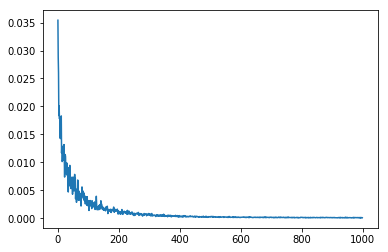

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]


<Figure size 432x288 with 0 Axes>

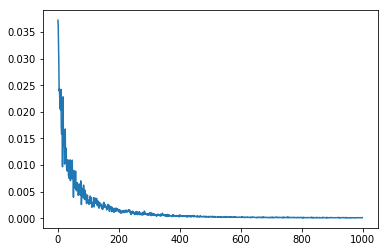

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


<Figure size 432x288 with 0 Axes>

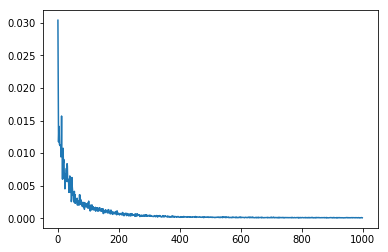

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80] [49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


<Figure size 432x288 with 0 Axes>

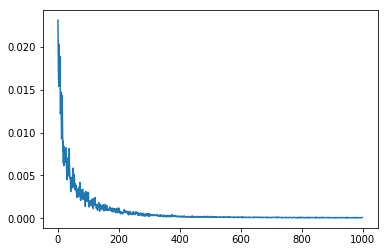

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]


<Figure size 432x288 with 0 Axes>

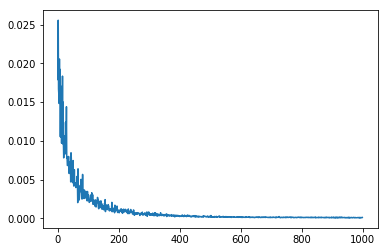

<Figure size 432x288 with 0 Axes>

In [145]:


for target in range(Y_data.shape[1]):
    if(target>0):
        break
    target=2
    selected_output = target
    bnn_wrapper = BNN_Wrapper(BNN_Dropout,output_size=1)
    
    kfold_times = 0
    kfold_limit = 5
    #kfold validation training
    kf = KFold(n_splits=5)
    f1_score_model_kfold=[]
    p_accurate_certain_kfold=[]
    p_accurate_uncertain_kfold=[]
    
    for train, test in kf.split(X_data,y=Y_data):
        
        if(kfold_times >kfold_limit):
            break
        print("%s %s" % (train, test))
        
    
        x_train=X_data[train]
        y_train=Y_data[train,selected_output]
        x_test=X_data[test]
        y_test=Y_data[test,selected_output]
        
        #simulate broken sensors on test set
        if simulate_broken_sensor == True:
            x_test_brokenSensor = Variable(torch.from_numpy(x_test).float()).repeat(x_train.shape[-1]+1,1,1,1)    
            for corrupted_sensor in range(x_train.shape[-1]):
                x_test_brokenSensor[corrupted_sensor,:,:,corrupted_sensor] =torch.randn_like(x_test_brokenSensor[corrupted_sensor,:,:,corrupted_sensor]) 
            x_test_brokenSensor = x_test_brokenSensor.view(-1,x_test_brokenSensor.shape[2],x_test_brokenSensor.shape[3])
            x_test_brokenSensor = x_test_brokenSensor.cpu().detach().numpy()
            x_test = copy(x_test_brokenSensor)
        
        
        y_test_tensor = Variable(torch.from_numpy(y_test).float())   
        if simulate_broken_sensor == True:
            y_test_tensor_repeated = y_test_tensor.repeat(x_train.shape[-1]+1,1)
            y_test_tensor_repeated = y_test_tensor_repeated.view(-1)    
        elif simulate_broken_sensor == False:
            y_test_tensor_repeated = y_test_tensor
    
        #perform feature extraction on train and test
        #df_feats_train = bnn_wrapper.extract_features(x_train)
        #df_feats_test = bnn_wrapper.extract_features(x_test)
        #x_train = df_feats_train.values 
        #x_test = df_feats_test.values 
        
        #train model
        bnn_wrapper.train_model(x_train,y_train,learning_rate= learning_rate,num_epochs = num_epochs)
    
        #predict using model
        y_pred_test,certainties,confidences = bnn_wrapper.predict_model_wUnc(x_test,num_samples=num_samples)
        
        #now form all the kfolds  
        DL_model_kfold.append(bnn_wrapper.trained_model)
        y_pred_kfold.append(y_pred_test)
        y_actuals_kfold.append(y_test_tensor_repeated.cpu().detach().numpy())
        certainties_kfold.append(np.array(certainties))
        confidences_kfold.append(np.array(confidences))
        kfold_times = kfold_times+1
        
        #evaluate model
        y_true_np=np.array(y_actuals_kfold).reshape(-1)
        y_pred_np=np.array(y_pred_kfold).reshape(-1)
        certainties_np = np.array(certainties_kfold).reshape(-1)
        
        #f1_score_model, p_accurate_certain, p_accurate_uncertain = bnn_wrapper.evaluate_model(y_true_np,y_pred_np,certainties_np,certainty_threshold=certainty_threshold)
        #f1_score_model_kfold.append(f1_score_model)
        #p_accurate_certain_kfold.append(p_accurate_certain)
        #p_accurate_uncertain_kfold.append(p_accurate_uncertain)
    
    #print("Target output: ", selected_output)
    #print("F1 SCORE: ",np.mean(f1_score_model_kfold),"+-",sem(f1_score_model_kfold), f1_score_model_kfold)
    #print("P(Acc | Certain): ",np.mean(p_accurate_certain_kfold),"+-",sem(p_accurate_certain_kfold),p_accurate_certain_kfold)
    #print("P(Acc | Uncertain): ",np.mean(p_accurate_uncertain_kfold),"+-",sem(p_accurate_uncertain_kfold),p_accurate_uncertain_kfold)

    #final_results.append([f1_score_model_kfold, p_accurate_certain_kfold, p_accurate_uncertain_kfold])
    
    #pickle.dump(bnn_wrapper, open( pickle_path+"bnn_wrapper_"+str(selected_output)+".p", "wb" ) )


In [146]:
y_actuals_kfold_np = []
y_pred_kfold_np = []
certainties_kfold_np = []
for i in range(len(y_actuals_kfold)):
    y_actuals_kfold_np +=y_actuals_kfold[i].tolist()
    y_pred_kfold_np += y_pred_kfold[i].tolist()
    certainties_kfold_np +=certainties_kfold[i].tolist()
    
y_actuals_kfold_np = np.array(y_actuals_kfold_np)
y_pred_kfold_np = np.array(y_pred_kfold_np)
certainties_kfold_np = np.array(certainties_kfold_np)

In [147]:
#y_actuals_kfold_np = np.array(y_actuals_kfold)
print(y_actuals_kfold_np.shape)
print(y_pred_kfold_np.shape)

(81,)
(81,)


In [169]:
mse_kfold = []

for i in range(len(y_actuals_kfold)):
    mse_kfold.append(mean_squared_error(y_actuals_kfold[i],y_pred_kfold[i]))
mse_kfold = np.array(mse_kfold)

mse_mean = np.mean(mse_kfold)
mse_std = np.std(mse_kfold)

print("MSE : "+str(mse_mean)+"+-"+str(mse_std))

MSE : 1334559900000000.0+-2669119800000000.0


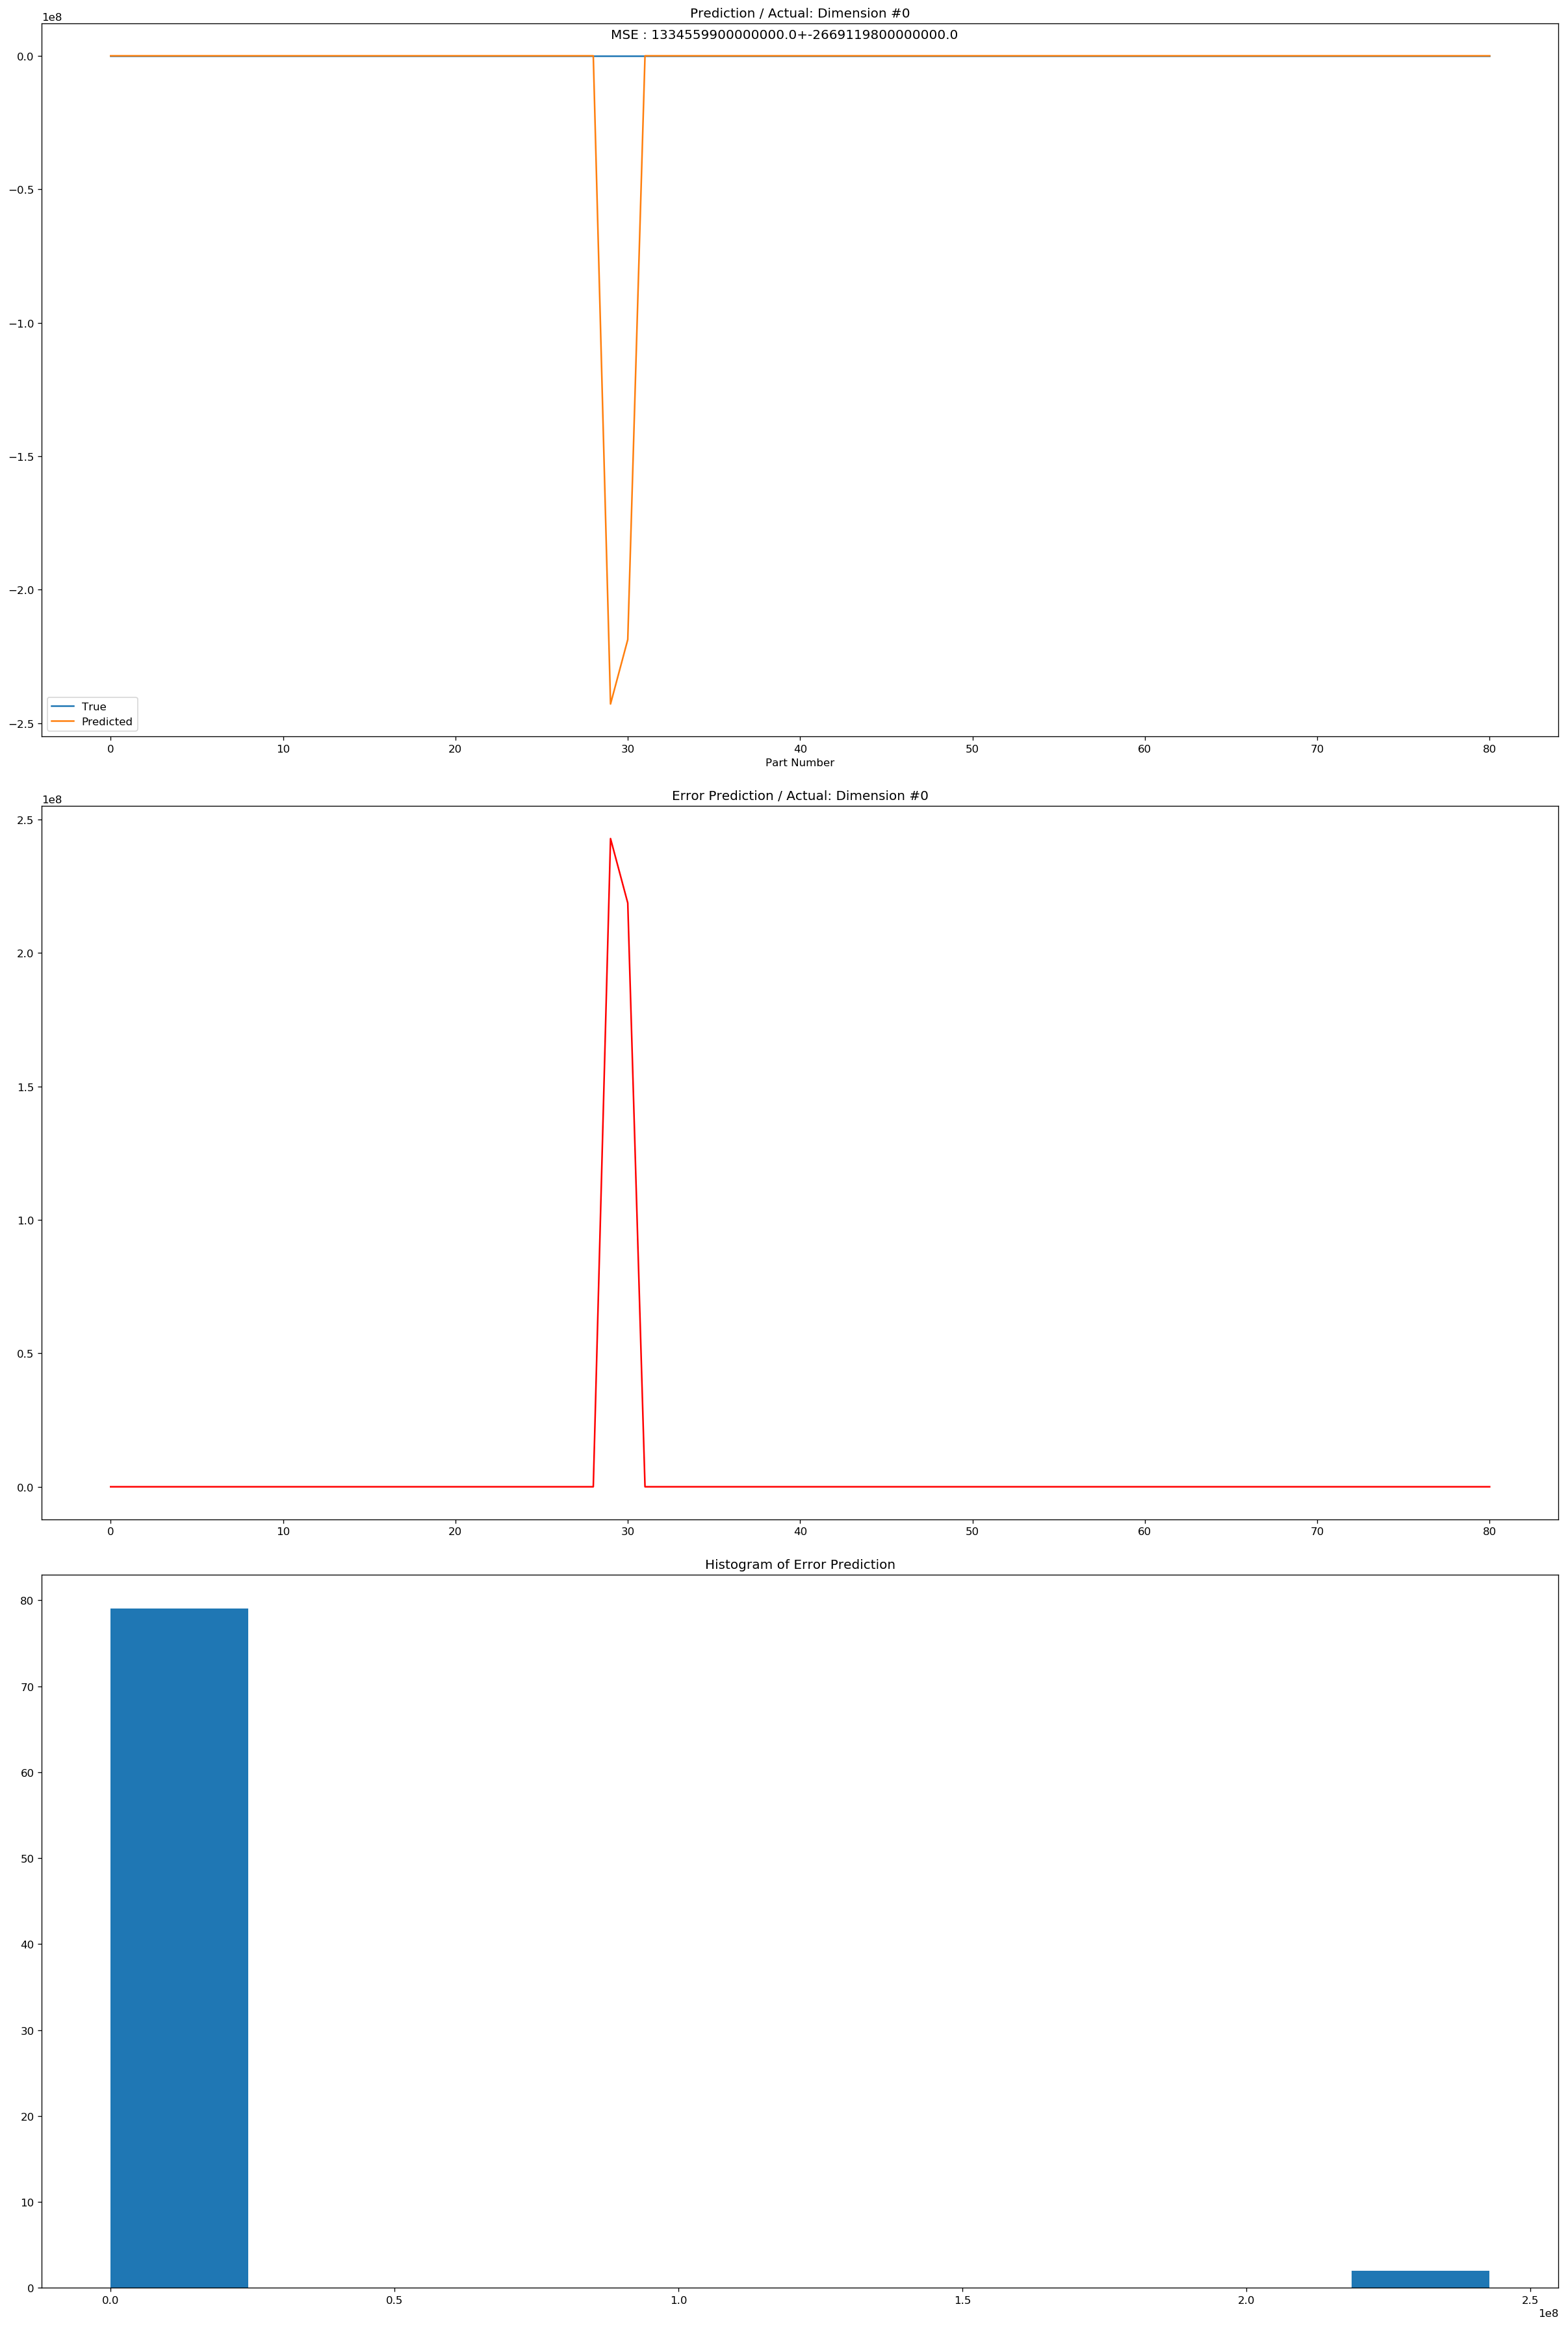

<Figure size 432x288 with 0 Axes>

In [170]:
error = y_actuals_kfold_np-y_pred_kfold_np
target_output_column =0

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, constrained_layout=True,dpi=120,figsize=(20,30))
ax1.plot(y_actuals_kfold_np)
ax1.plot(y_pred_kfold_np)
ax1.legend(['True','Predicted'])
ax1.set_xlabel("Part Number")
ax1.set_title("Prediction / Actual: Dimension #"+str(target_output_column))
ax2.plot(error,color='r')
ax2.set_title("Error Prediction / Actual: Dimension #"+str(target_output_column))
ax3.hist(error)
ax3.set_title("Histogram of Error Prediction")
fig.suptitle("MSE : "+str(mse_mean)+"+-"+str(mse_std))       
plt.show()
plt.clf()

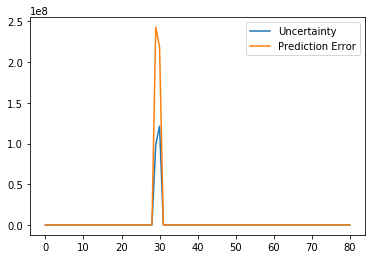

In [171]:
plt.plot(certainties_kfold_np)
plt.plot(error)
plt.legend(["Uncertainty","Prediction Error"])

In [172]:
np.corrcoef(np.abs(error),certainties_kfold_np)[0][1]

0.9877147054694387

## Filter based on uncertainty

Seems that there are some parts which are extremely uncertain

Hence, we shall filter out the uncertain predictions




[1.07059833e-02 5.76947033e-01 1.02801910e-02 9.66289919e-03
 8.34316388e-03 9.40095261e-03 7.58376857e-03 1.00008715e-02
 7.04450207e-03 1.02672409e-02 8.85236356e-03 5.98060293e-03
 1.27659664e-02 1.22300535e-02 6.59971917e-03 9.72528569e-03
 9.88273416e-03 5.93050383e-03 7.73750572e-03 1.04398560e-02
 8.04151222e-03 9.59587377e-03 7.37945363e-03 9.88584664e-03
 9.20060463e-03 5.76107204e-03 7.20160129e-03 8.24918691e-03
 8.32929835e-03 9.86228000e+07 1.21294840e+08 8.96333251e-03
 6.69704424e-03 1.43969208e-02 4.85511729e-03 5.77439507e-03
 8.93178023e-03 8.04019533e-03 6.94455393e-03 4.93741687e-03
 7.77809648e-03 9.44803562e-03 5.12724742e-03 7.27029383e-01
 5.85735869e-03 6.13338174e-03 5.06313622e-01 7.48239690e-03
 3.60255502e-02 6.36920054e-03 8.51262454e-03 7.20249908e-03
 5.75369643e-03 1.19429128e-02 7.07136979e-03 5.50963404e-03
 7.61630014e-03 8.46322440e-03 7.01505737e-03 9.59797576e-03
 7.17703067e-03 5.97412419e-03 6.17862819e-03 9.11261141e-03
 8.69008340e-03 8.958219

(array([79.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([4.85511729e-03, 1.21294840e+07, 2.42589680e+07, 3.63884520e+07,
        4.85179360e+07, 6.06474200e+07, 7.27769040e+07, 8.49063880e+07,
        9.70358720e+07, 1.09165356e+08, 1.21294840e+08]),
 <a list of 10 Patch objects>)

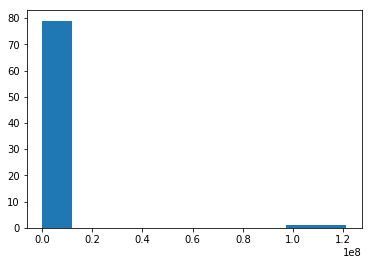

In [152]:
print(certainties_kfold_np)
plt.hist(certainties_kfold_np)

In [153]:
def reject_outliers(data, threshold):    
    #condition = abs(data - np.mean(data)) < m * np.std(data)
    select_condition = data<=threshold
    rejected_index = np.argwhere(select_condition == False)
    rejected_index = rejected_index.reshape(-1)
    return data[select_condition],rejected_index


In [181]:
uncertainty_threshold = 0.1
certainties_kfold_np_filtered,rejected_index = reject_outliers(certainties_kfold_np,uncertainty_threshold)
print(certainties_kfold_np_filtered)
print(rejected_index)

[0.01070598 0.01028019 0.0096629  0.00834316 0.00940095 0.00758377
 0.01000087 0.0070445  0.01026724 0.00885236 0.0059806  0.01276597
 0.01223005 0.00659972 0.00972529 0.00988273 0.0059305  0.00773751
 0.01043986 0.00804151 0.00959587 0.00737945 0.00988585 0.0092006
 0.00576107 0.0072016  0.00824919 0.0083293  0.00896333 0.00669704
 0.01439692 0.00485512 0.0057744  0.00893178 0.0080402  0.00694455
 0.00493742 0.0077781  0.00944804 0.00512725 0.00585736 0.00613338
 0.0074824  0.03602555 0.0063692  0.00851262 0.0072025  0.0057537
 0.01194291 0.00707137 0.00550963 0.0076163  0.00846322 0.00701506
 0.00959798 0.00717703 0.00597412 0.00617863 0.00911261 0.00869008
 0.00895822 0.00869376 0.00629016 0.00814303 0.01003879 0.00814024
 0.01203783 0.00751337 0.00726703 0.00942093 0.00725877 0.00602982
 0.00752176 0.00687627 0.00791787 0.00898345]
[ 1 29 30 43 46]


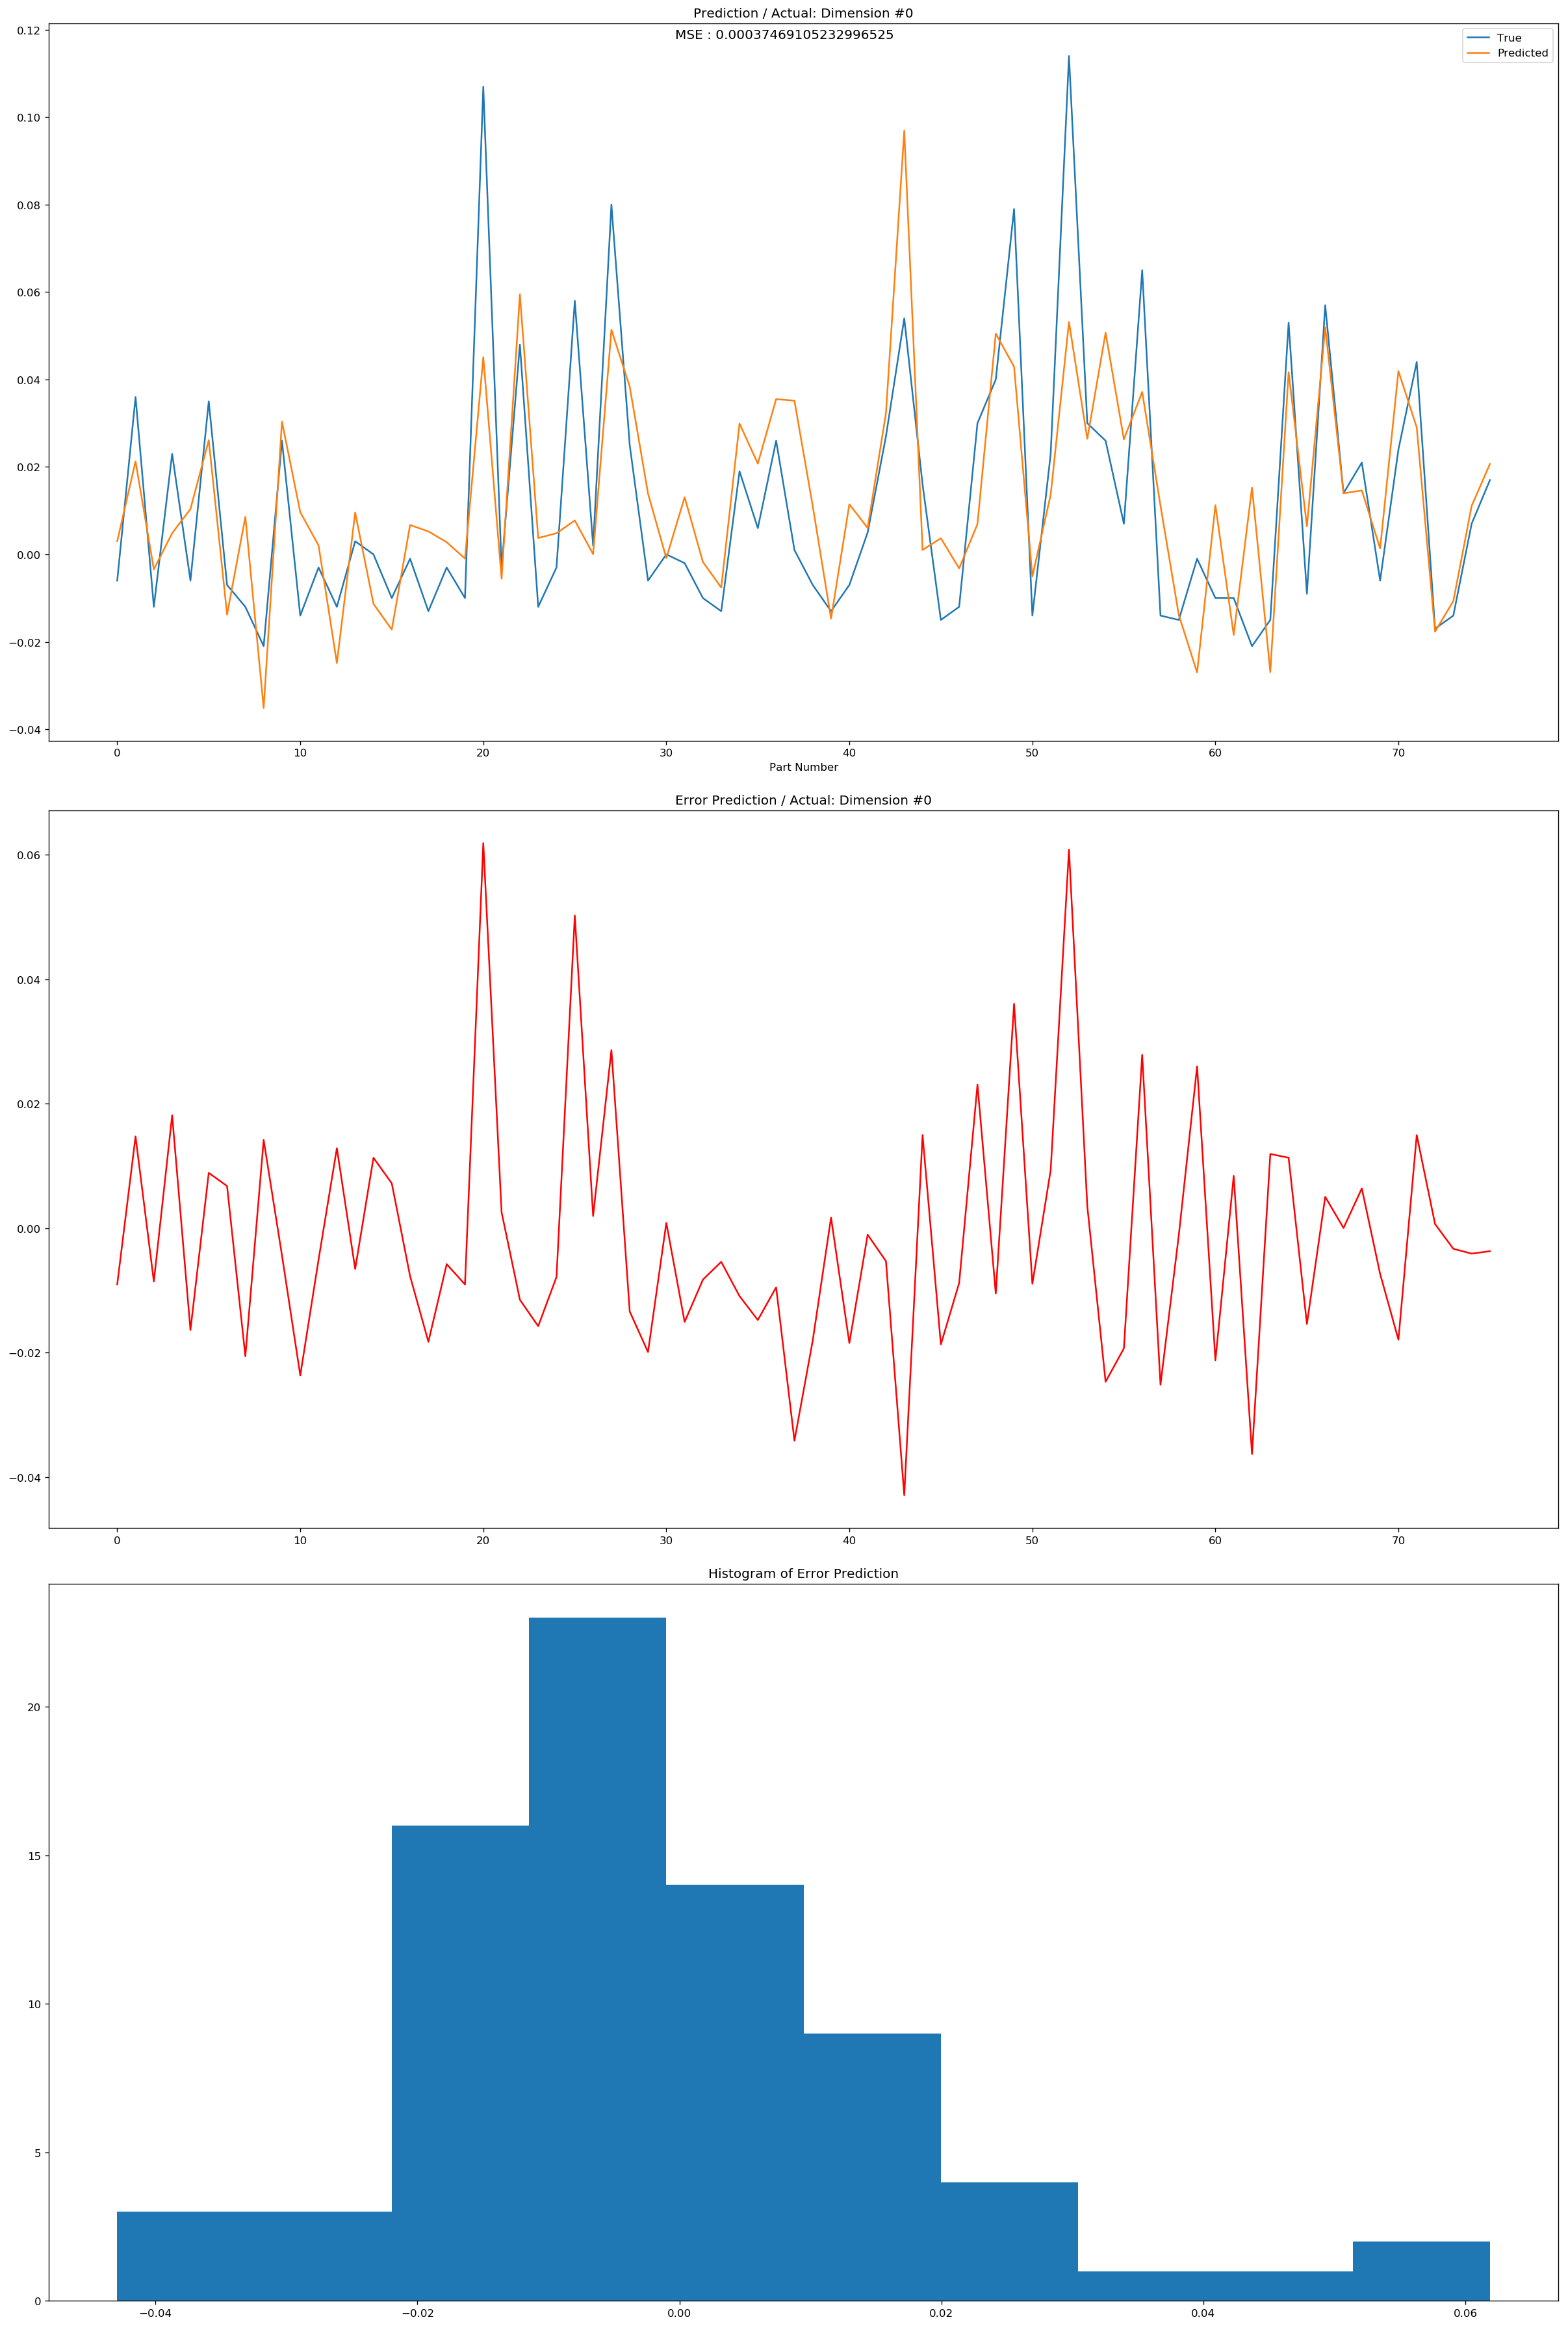

<Figure size 432x288 with 0 Axes>

In [182]:
filtered_y_actuals = np.delete(y_actuals_kfold_np,rejected_index)
filtered_y_preds = np.delete(y_pred_kfold_np,rejected_index)
filtered_certainties = np.delete(certainties_kfold_np,rejected_index)
filtered_error = filtered_y_actuals-filtered_y_preds
target_output_column =0

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, constrained_layout=True,dpi=120,figsize=(20,30))
ax1.plot(filtered_y_actuals)
ax1.plot(filtered_y_preds)
ax1.legend(['True','Predicted'])
ax1.set_xlabel("Part Number")
ax1.set_title("Prediction / Actual: Dimension #"+str(target_output_column))
ax2.plot(filtered_error,color='r')
ax2.set_title("Error Prediction / Actual: Dimension #"+str(target_output_column))
ax3.hist(filtered_error)
ax3.set_title("Histogram of Error Prediction")
fig.suptitle("MSE : "+str(mean_squared_error(filtered_y_actuals,filtered_y_preds)))       
plt.show()
plt.clf()

In [183]:
np.corrcoef(filtered_y_actuals,filtered_y_preds)[0][1]

0.7539765823255291

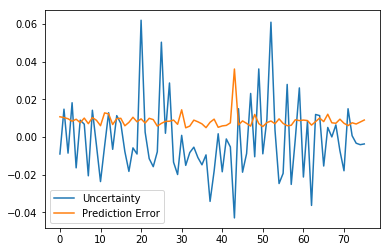

In [179]:
plt.plot(filtered_error)
plt.plot(filtered_certainties)
plt.legend(["Uncertainty","Prediction Error"])

In [180]:
np.corrcoef(np.abs(filtered_error),filtered_certainties)[0][1]

0.16627602349260803